Code to analyze the Beta diversity

In [14]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import pandas as pd
import qiime2 as q2
from skbio import OrdinationResults
from qiime2 import Visualization
from seaborn import scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
#all variables
Data_raw='Data/raw'
Data_classified='Data/classified'
Data_diversity='Data/diversity'

<div style="background-color: skyblue; padding: 10px;">
    Titles
    </div>
<div style="background-color: aliceblue; padding: 10px;">
    Results

<div style="background-color: skyblue; padding: 10px;">

## Creating the necessary files  
**Creating files on overall data**  
Diversity core metrics could be created on Jupyterhub

Adjusting merged_output.tsv to adapt for analysis without problems (no spaces in column titles)

In [44]:
df = pd.read_csv(f'{Data_raw}/merged_output.tsv', sep='\t')
# Keep first column name, modify the rest
new_columns = [df.columns[0]] + [col.replace(' ', '_').replace('/', '_') for col in df.columns[1:]]
df.columns = new_columns
df.to_csv(f'{Data_raw}/merged_output_usable.tsv', sep='\t', index=False)

Creating one metadata file with only metadata for people who filled out survey

In [79]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

columns_to_check = ["start_time", "completion_time"]

df_filtered = df.dropna(subset=columns_to_check)

df_filtered.to_csv("Data/diversity/filtered-metadata/meta_survey.tsv", sep="\t", index=False)

**Creating the files on all metadata**

In [9]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/diversity/core-metrics-results-merged/jaccard

The following code was then submitted as a job on Euler, due to too little memory capacity on Jupyterhub

In [ ]:
#!/bin/bash
#SBATCH --job-name=kmerizer
#SBATCH --time=04:00:00
#SBATCH --mem-per-cpu=32GB
#SBATCH --cpus-per-task=4
#SBATCH --output=kmerizer.log
source /cluster/home/nschwager/miniconda3/etc/profile.d/conda.sh
source ~/.bashrc
conda activate qiime2-amplicon-2025.10
qiime kmerizer core-metrics \
  --i-table /cluster/home/nschwager/kmerizer/table-filtered.qza \
  --i-sequences /cluster/home/nschwager/kmerizer/rep-seqs-filtered.qza \
  --m-metadata-file /cluster/home/nschwager/kmerizer/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir /cluster/scratch/home/kmerizer/kmerizer-results-merged

**Creating files on just sourdough data**  
First filtering the coresponding tables

In [35]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='sourdough'" \
  --o-filtered-table $Data_classified/table-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-sourdough_only.qza


In [40]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-sourdough_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-sourdough_only.qza


Creating the metrics files

In [37]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-sourdough-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-sourdough-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-sourdough-only/bray_curtis_di

In [42]:
!qiime kmerizer core-metrics \
  --i-table $Data_classified/table-filtered-sourdough_only.qza \
  --i-sequences $Data_classified/rep-seqs-filtered-sourdough_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/kmerizer-results-merged-sourdough-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/rarefied_table.qza
Saved FeatureTable[Frequency] to: Data/diversity/kmerizer-results-merged-sourdough-only/kmer_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/kmerizer-results-merged-sourdough-only/shannon_vector.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza
Saved PCoAResu

**Creating files on just hand data**  
Filtering first

In [3]:
!qiime feature-table filter-samples \
  --i-table $Data_classified/table-filtered.qza \
  --m-metadata-file $Data_raw/merged_output.tsv  \
  --p-where "sample_type='hand_swabs'" \
  --o-filtered-table $Data_classified/table-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/classified/table-filtered-hand_only.qza


In [4]:
!qiime feature-table filter-seqs \
  --i-data $Data_classified/rep-seqs-filtered.qza \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --o-filtered-data $Data_classified/rep-seqs-filtered-hand_only.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: Data/classified/rep-seqs-filtered-hand_only.qza


Creating the metric files

In [5]:
! qiime diversity core-metrics \
  --i-table $Data_classified/table-filtered-hand_only.qza \
  --m-metadata-file $Data_raw/merged_output.tsv\
  --p-sampling-depth 3000 \
  --output-dir $Data_diversity/core-metrics-results-merged-hand-only

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/diversity/core-metrics-results-merged-hand-only/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/diversity/core-metrics-results-merged-hand-only/evenness_vector.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/diversity/core-metrics-results-merged-hand-only/bray_curtis_distance_matrix.qza
Saved PCoARe

In [ ]:
#!/bin/bash
#SBATCH --job-name=kmerizer-hand
#SBATCH --time=04:00:00
#SBATCH --mem-per-cpu=32GB
#SBATCH --cpus-per-task=4
#SBATCH --output=kmerizer-hand.log
source /cluster/home/nschwager/miniconda3/etc/profile.d/conda.sh
source ~/.bashrc
conda activate qiime2-amplicon-2025.10
qiime kmerizer core-metrics \
  --i-table /cluster/home/nschwager/kmerizer-hand/table-filtered-hand_only.qza \
  --i-sequences /cluster/home/nschwager/kmerizer-hand/rep-seqs-filtered-hand_only.qza \
  --m-metadata-file /cluster/home/nschwager/kmerizer-hand/merged_output.tsv \
  --p-sampling-depth 3000 \
  --output-dir /cluster/home/nschwager/kmerizer-hand/kmerizer-results-merged-hand-only

Filter distance matrix for people who fileld out survey

In [7]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza


In [8]:
!qiime diversity filter-distance-matrix \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --o-filtered-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza


<div style="background-color: skyblue; padding: 10px;">

## Analysis of whole Metadata ITS

In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/scatterplot.qzv")

<visualization: Visualization uuid: 6b96d4f3-0d61-4d09-a49d-742e01936bd8>

<div style="background-color: aliceblue; padding: 10px;">
    
- Hand swabs and sourdough communities show different sets of fungis and different relative abundance  
- when doing day as y-axis and bray-curtis as x-axis there seems to be more and more similarities for the sourdoughs to the hand over time  
- there appears to be no difference between right & left hand

In [4]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: 10abcc51-22c7-4781-88c1-7b1a06a76d41>

**Comparison of the hand & sourdough environment**  

Bray-curtis

In [15]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv


In [3]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/bray_curtis-sample_type-significance.qzv")

<visualization: Visualization uuid: b73d8238-ebd1-4c75-a492-d57ad15b859e>

Jaccard

In [19]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --m-metadata-column sample_type \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged/jaccard-sample_type-significance.qzv


In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged/jaccard-sample_type-significance.qzv")

<visualization: Visualization uuid: b43ed32f-e6c1-486f-a27f-634feacb2161>

<div style="background-color: aliceblue; padding: 10px;">

- Comparison of the sample types (handswabs vs sourdough) shows a significant difference in the composition and abundance (bray curtis: p value of 0.001, q-value of 0.0025 & F value of 245.525768; jaccard metric: p of 0.001, q-value of 0.001429 and pseudo F-value of 102.962864) 
- which indicates a high proportion of features that are not shared between hand and sourdough overall

**Comparison of hand & sourdough**

In [ ]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column sample_type
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged/bray-curtis-hand-assimilation-over-time.qzv

**Comparison of hand**  

Bray-Curtis

In [15]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results/bray_curtis-hand-significance.qzv

Visualization.load(f"{Data_diversity}/kmerizer-results/bray_curtis-hand-significance.qzv")

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results/bray_curtis-hand-significance.qzv


<visualization: Visualization uuid: cee4cb1c-cccb-4c23-8a10-7daf1c2a4d12>

Jaccard

In [16]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/20250913_metadata_ITS.tsv \
    --m-metadata-column hand \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results/jaccard-hand-significance.qzv

Visualization.load(f"{Data_diversity}/kmerizer-results/jaccard-hand-significance.qzv")

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results/jaccard-hand-significance.qzv


<visualization: Visualization uuid: a7eb996b-1310-4c83-bd3f-abc9db437329>

<div style="background-color: aliceblue; padding: 10px;">

- there is no difference in abundance or composition between right & left hand
- Bray-Curtis: p-value: 0.766, q-value: 0.766, pseudo F-value: 0.746564  
- Jaccard: p & q value: 0.297 and pseude F-value: 1.024582

<div style="background-color: skyblue; padding: 10px;">

## Analysis of filtered only Sourdough metadata

In [22]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/scatterplot.qzv")

<visualization: Visualization uuid: 0b30dadc-23cd-446c-8d58-e77aca29e022>

<div style="background-color: aliceblue; padding: 10px;">

- it seems like the background plays less and less a role (xField Bray-Curtis 1 yField day) and it seems to explain most of the difference in composition in the beginning)  
- if day21 aromas = null means, that they were no aromas, then lower pH is associated with more aromas

In [5]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-sourdough-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: a4ac9a6e-44df-4f67-b0ad-23c7d51c4e66>

<div style="background-color: aliceblue; padding: 10px;">

- strong difference between background sterile & non-sterile
- some aromas on day 28 seem to appear either only on the sterile / non-sterile side

**Control that no effect trough different plates**

Bray-curtis

In [73]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv


In [74]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-plate.qzv")

<visualization: Visualization uuid: f841e978-6248-427c-88c1-64e884c3e478>

Jaccard

In [75]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv\
    --m-metadata-column plate \
    --p-pairwise \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv


In [76]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-plate.qzv")

<visualization: Visualization uuid: d67f9559-9f12-44f1-807f-0f8f7e5a3f9f>

<div style="background-color: aliceblue; padding: 10px;">
    
- no influence of plate on sourdough composition -> good

**Effect of Background on Sourdough**

In [3]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv


In [4]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray-curtis-background-difference-over-time.qzv")

<visualization: Visualization uuid: ab9b6350-054d-4561-b1d8-7ba8ad962bc2>

Trying to plot the distance as a scatterplot to see the distribution of change

In [15]:
effect_background = pd.read_csv(f'{Data_diversity}/kmerizer-results-merged-sourdough-only/pairs-effect-of-background-sourdough.tsv', index_col=0, sep='\t')
effect_background.shape

(34, 3)

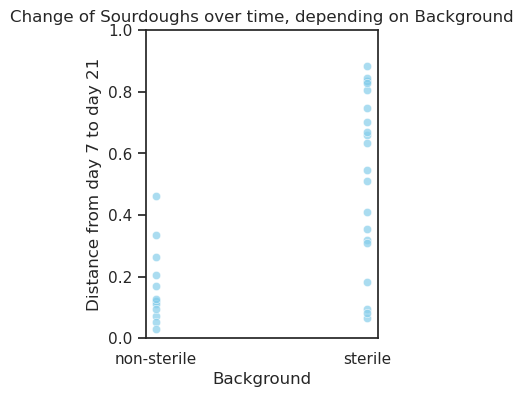

In [28]:
mapping = {
    effect_background["Group"].unique()[0]: 0.25,
    effect_background["Group"].unique()[1]: 0.75
}

sns.set(rc={'figure.figsize':(3, 4)}, style='white')

with sns.plotting_context("notebook", font_scale=1):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        effect_background, 
        x='Group', 
        y='Distance',
        alpha=0.7,
        color='skyblue')
    
    
    # matplotlib's customization
    ax.set_xlabel('Background')
    ax.set_ylabel('Distance from day 7 to day 21')
    ax.set_ylim((0,1))

ax.tick_params(axis='y', which='major', left=True)

ax.set_title('Change of Sourdoughs over time, depending on Background', fontsize=12);

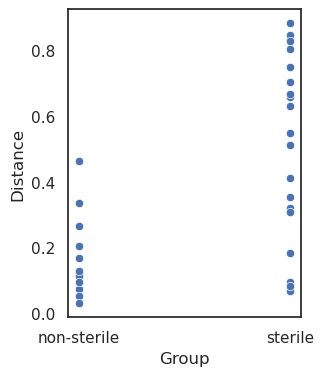

In [18]:
sns.set(rc={'figure.figsize':(3, 4)}, style='white')
sns.scatterplot(data=effect_background, x="Group", y="Distance")
plt.show()

In [5]:
!qiime longitudinal pairwise-distances \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix.qza \
    --m-metadata-file $Data_raw/merged_output.tsv \
    --p-state-column day \
    --p-group-column background \
    --p-state-1 7.0 \
    --p-state-2 21.0 \
    --p-individual-id-column person-id \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv


In [3]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard-background-difference-over-time.qzv")

<visualization: Visualization uuid: edb5455d-b41f-4f4b-9e04-e809917eb317>

<div style="background-color: aliceblue; padding: 10px;">
    
There is a highly significant difference in change of the sourdough fungal abundance (significant bray-curtis), but not in composition (non-significant jaccard) over time, depending on the background. 
There are samples also for the sterile background that also almost didn't change and some that did change a lot.

**Effect of latitude & longitude**

Bray-curtis

In [99]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv


In [100]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_location.qzv")

<visualization: Visualization uuid: 36918420-c10c-4184-8e0a-8f7b345a2dd2>

Jaccard

In [102]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_survey.tsv  \
    --p-formula "latitude*longitude" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_location.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_location.qzv


In [103]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_location.qzv")

<visualization: Visualization uuid: 901fec1b-083b-47ee-af01-f8fb657141eb>

<div style="background-color: aliceblue; padding: 10px;">

- geographical location doesn't explain difference in abundance & composition of the sourdough's

**Effect of pets**

Fill in NaN's for 0 because adonis can't work with NaN's and we already have just the metadata for people who filled out the survey

In [96]:
df = pd.read_csv("Data/raw/merged_output_usable.tsv", sep="\t")

columns_to_check = ["guinea_pig", "cat", "dog", "turtle", "fish"]

df[columns_to_check] = df[columns_to_check].fillna(0.0)
df.to_csv("Data/diversity/filtered-metadata/meta_pets.tsv", sep="\t", index=False)

Bray curtis (no need to filter distance matrix, as same as before (survey))

In [106]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv


In [108]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/bray_curtis_pets.qzv")

<visualization: Visualization uuid: c8e8e43b-bff6-4fea-8d0a-3dc2a7e850c4>

Jaccard (no need to filter distance matrix, as same as before (survey))

In [107]:
! qiime diversity adonis \
    --i-distance-matrix $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_distance_matrix_survey.qza \
    --m-metadata-file $Data_diversity/filtered-metadata/meta_pets.tsv  \
    --p-formula "guinea_pig*cat*dog*turtle*fish" \
    --o-visualization $Data_diversity/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/diversity/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv


In [109]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-sourdough-only/jaccard_pets.qzv")

<visualization: Visualization uuid: 02ec582f-98c5-4197-a723-31e74fec44c5>

<div style="background-color: aliceblue; padding: 10px;">

Pets do not have an influence on fungal composition or abundance

<div style="background-color: skyblue; padding: 10px;">

## Analysis of filtered only Hand metadata

In [13]:
Visualization.load(f"{Data_diversity}/core-metrics-results-merged-hand-only/bray_curtis_emperor.qzv")

<visualization: Visualization uuid: 3840d61a-fb54-4b8f-9f28-748a37b166c7>

In [23]:
Visualization.load(f"{Data_diversity}/kmerizer-results-merged-hand-only/scatterplot.qzv")

<visualization: Visualization uuid: f42f43cd-7c1f-4628-91cd-9e64612750b2>

<div style="background-color: aliceblue; padding: 10px;">
- no difference of background on hand fungal composition visible


<div style="background-color: skyblue; padding: 10px;">

## diversity bioenv trials to gain insight in most associated variables for beta diversity

Job submitted on Euler (took too long here)

In [ ]:
#!/bin/bash
#SBATCH --job-name=bioenv
#SBATCH --time=04:00:00
#SBATCH --mem-per-cpu=32GB
#SBATCH --cpus-per-task=4
#SBATCH --output=bioenv.log
source /cluster/home/nschwager/miniconda3/etc/profile.d/conda.sh
source ~/.bashrc
conda activate qiime2-amplicon-2025.10
qiime diversity bioenv \
    --i-distance-matrix /cluster/home/nschwager/bioenv/jaccard_distance_matrix.qza \
    --m-metadata-file /cluster/home/nschwager/bioenv/merged_output_usable.tsv \
    --o-visualization /cluster/home/nschwager/bioenvresults/jaccard-diversity-bioenv.qzv
qiime diversity bioenv \
    --i-distance-matrix /cluster/home/nschwager/bioenv/bray_curtis_distance_matrix.qza \
    --m-metadata-file /cluster/home/nschwager/bioenv/merged_output_usable.tsv \
    --o-visualization /cluster/home/nschwager/bioenvresults/bray_curtis-diversity-bioenv.qzv

<div style="background-color: aliceblue; padding: 10px;">

